# Rasterization
We want to burn a polygon into a raster.

In [1]:
import os
#import glob
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("NumPy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

NumPy version: 1.23.1
GDAL version: 3.5.1
GeoPandas version: 0.11.1


In [2]:
path = 'data/raster/Landsat/Italy/'
band2_fn = os.path.join(path, 'LC09_L1TP_190031_20230214_20230310_02_T1_B2.TIF')

Image format: TIFF
Shape (rows, cols): (7841, 7951)
Mode: I;16


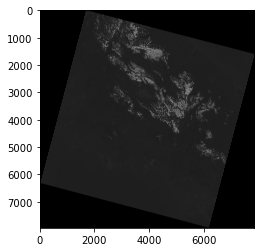

In [3]:
im_band2 = Image.open(band2_fn)
print('Image format: {}\nShape (rows, cols): {}\nMode: {}'.format(im_band2.format, im_band2.size, im_band2.mode))
plt.imshow(im_band2, cmap='gray')

In [4]:
band2_ds = gdal.Open(band2_fn)
rows = band2_ds.RasterXSize
cols = band2_ds.RasterYSize
print('Rows: {0}\nColumns: {1}'.format(rows, cols))

Rows: 7841
Columns: 7951


In [5]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = band2_ds.GetGeoTransform()
print('x origin: {} m.\ny origin: {} m.\nx pixel res.: {} m.\ny pixel res: {} m.'.format(x_origin, 
                                                                                         y_origin, 
                                                                                         x_pixel_resolution, 
                                                                                         y_pixel_resolution))

x origin: 264885.0 m.
y origin: 4742715.0 m.
x pixel res.: 30.0 m.
y pixel res: -30.0 m.


In [31]:
x0 = 105000 # space shift of the subset origin from the image origin in meters
y0 = -165000
delta_x = 20000 # subset east shift
delta_y = -20000 # subset south shift
x_nw = x0 + x_origin # x coordinate of the subset origin NW
y_nw = y0 + y_origin # y coordinate of the subset origin NW
print('NW (x, y): ({}, {})\n'.format(x_nw, y_nw))
x_se = x_nw + delta_x # x coordinate of the subset origin SE
y_se = y_nw + delta_y # x coordinate of the subset origin 
print('SE (x, y): ({}, {})\n'.format(x_se, y_se))

NW (x, y): (369885.0, 4577715.0)

SE (x, y): (389885.0, 4557715.0)



In [32]:
rows = round((x_se - x_nw) / x_pixel_resolution)
cols = round((y_se - y_nw) / abs(y_pixel_resolution))
rows, cols

(667, -667)

In [33]:
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box
nw = Point(x_nw, y_nw)
se = Point(x_se, y_se)
poly = ogr.Geometry(ogr.wkbLinearRing)
poly.AddPoint(x_nw, y_nw)
poly.AddPoint(x_nw, y_se)
poly.AddPoint(x_se, y_se)
poly.AddPoint(x_se, y_nw)
poly.AddPoint(x_nw, y_nw)
bbox = ogr.Geometry(ogr.wkbPolygon)
bbox.AddGeometry(poly)
print(bbox.ExportToWkt())

POLYGON ((369885 4577715 0,369885 4557715 0,389885 4557715 0,389885 4577715 0,369885 4577715 0))


In [35]:
import sys
json_driver = ogr.GetDriverByName('GeoJSON')
json_fn = os.path.join(path,'bounding_box5.json')
if os.path.exists(json_fn):
    layer = None
    json_ds = None
    json_driver.DeleteDataSource(json_fn)
json_ds = json_driver.CreateDataSource(json_fn)
srs = ogr.osr.SpatialReference()
srs.ImportFromEPSG(32633)
if json_ds is None:
    sys.exit('Could not create {0}.'.format(json_fn))
layer = json_ds.CreateLayer('bounding box', srs, ogr.wkbPolygon)
featureDefn = layer.GetLayerDefn()

outFeature = ogr.Feature(featureDefn)

outFeature.SetGeometry(bbox)

layer.CreateFeature(outFeature)

del outFeature
del layer
del json_ds 